# **Padchest Dataset Exploration and Preliminary Cleaning**
A large, labeled chest X-ray dataset with 160,000 images from 67,000 patients, interpreted by radiologists at Spain's San Juan Hospital (2009-2017), is introduced. It covers various views, annotated with 174 findings, 19 diagnoses, and 104 anatomical locations, organized hierarchically and aligned with UMLS. While 27% were manually labeled, the rest used a supervised approach via a recurrent neural network with attention. Validation achieved 0.93 Micro-F1 score on an independent set. Notably extensive, it's suitable for training radiograph-related supervised models and is the first to feature Spanish radiographic reports.

In [1]:
!pip install -U deep-translator >null

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ast
import time
import re
import seaborn as sns
from deep_translator import GoogleTranslator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dtypes = {'column19': 'str', 'column20': 'str'}  # Replace 'column19' and 'column20' with actual column names
df = pd.read_csv("/kaggle/input/padchest-es/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv", index_col=0)
df.head()

/tmp/ipykernel_20/702035386.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/padchest-es/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv", index_col=0)


,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,MethodProjection,...,ExposureTime,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,-1.42,4765777,sin hallazg patolog edad pacient .,Physician,['normal'],[],"[['normal'], ['normal']]",[],[]
1,135803415504923515076821959678074435083_fzis7d...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,LATERAL,L,Manual review of DICOM fields,...,25,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378']
2,135803415504923515076821959678074435083_fzis7b...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,10,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378']
3,113855343774216031107737439268243531979_3k951l...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,POSTEROANTERIOR,PA,Manual review of DICOM fields,...,8,None,4955977,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151']
4,113855343774216031107737439268243531979_3k951n...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,LATERAL,L,Manual review of DICOM fields,...,20,None,4955977,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151']


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160861 entries, 0 to 160860
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ImageID                          160861 non-null  object 
 1   ImageDir                         160861 non-null  int64  
 2   StudyDate_DICOM                  160861 non-null  int64  
 3   StudyID                          160861 non-null  object 
 4   PatientID                        160861 non-null  object 
 5   PatientBirth                     160855 non-null  float64
 6   PatientSex_DICOM                 160857 non-null  object 
 7   ViewPosition_DICOM               91776 non-null   object 
 8   Projection                       160861 non-null  object 
 9   MethodProjection                 160861 non-null  object 
 10  Pediatric                        160861 non-null  object 
 11  Modality_DICOM                   160861 non-null  object 
 12  Ma

#### **Observations**

The fields which seem to be important and userful are :

* ImageID : Unique identifier for each chest X-ray image. "...png"
* ImageDir : Directory where the image is located.
* StudyDate_DICOM : Date of the study associated with the image in the DICOM format.
* PatientID : Unique identifier for the patient.
* PatientBirth : Year of birth of the patient.
* Pediatric : PED if the image acquisition followed a pediatric protocol
* PatientSex_DICOM : Sex of the patient in the DICOM format. M male, F female, O other
* ViewPosition_DICOM : Position of the view in which the X-ray was taken (e.g., PA, Lateral).
* Projection : the type of medical imaging projection technique used to acquire the image.
* ReportID : LabelsLocalizationsBySentence
* Report : Text of the radiology report.
* MethodLabel : Method used for labeling.
* Labels : List of labels associated with the image.
* Localizations : List of localizations corresponding to the labels.
* LabelsLocalizationsBySentence : Labels and localizations grouped by sentence.

In [5]:
selected_columns = ['ImageID', 'ImageDir', 'StudyDate_DICOM', 'StudyID', 'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM', 'Projection', 'ReportID', 'Pediatric', 'Report', 'MethodLabel', 'Labels', 'Localizations', 'LabelsLocalizationsBySentence']
df = df[selected_columns]
df.head()

,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence
0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,PA,4765777,No,sin hallazg patolog edad pacient .,Physician,['normal'],[],"[['normal'], ['normal']]"
1,135803415504923515076821959678074435083_fzis7d...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,LATERAL,L,4991845,No,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']..."
2,135803415504923515076821959678074435083_fzis7b...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929.0,M,POSTEROANTERIOR,PA,4991845,No,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']..."
3,113855343774216031107737439268243531979_3k951l...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,POSTEROANTERIOR,PA,4955977,No,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n..."
4,113855343774216031107737439268243531979_3k951n...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925.0,F,LATERAL,L,4955977,No,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160861 entries, 0 to 160860
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ImageID                        160861 non-null  object 
 1   ImageDir                       160861 non-null  int64  
 2   StudyDate_DICOM                160861 non-null  int64  
 3   StudyID                        160861 non-null  object 
 4   PatientID                      160861 non-null  object 
 5   PatientBirth                   160855 non-null  float64
 6   PatientSex_DICOM               160857 non-null  object 
 7   ViewPosition_DICOM             91776 non-null   object 
 8   Projection                     160861 non-null  object 
 9   ReportID                       160861 non-null  int64  
 10  Pediatric                      160861 non-null  object 
 11  Report                         160745 non-null  object 
 12  MethodLabel                   

## **Data Cleaning**

In [7]:
# Remove duplicated rows info
df = df.iloc[df[df.drop(['ImageID'], axis=1).duplicated()==False].index].reset_index(drop=True)

### **PatientBirth, StudyDate_DICOM and PatientSex_DICOM Features**
Create new feature "PatientAge" and check the distribution PatientAge among PatientSex.

In [8]:
df['PatientAge'] = df.StudyDate_DICOM.apply(lambda x : float(str(x)[:4])) - df.PatientBirth
#df.drop(columns=['PatientBirth', 'StudyDate_DICOM'], axis=1, inplace=True)

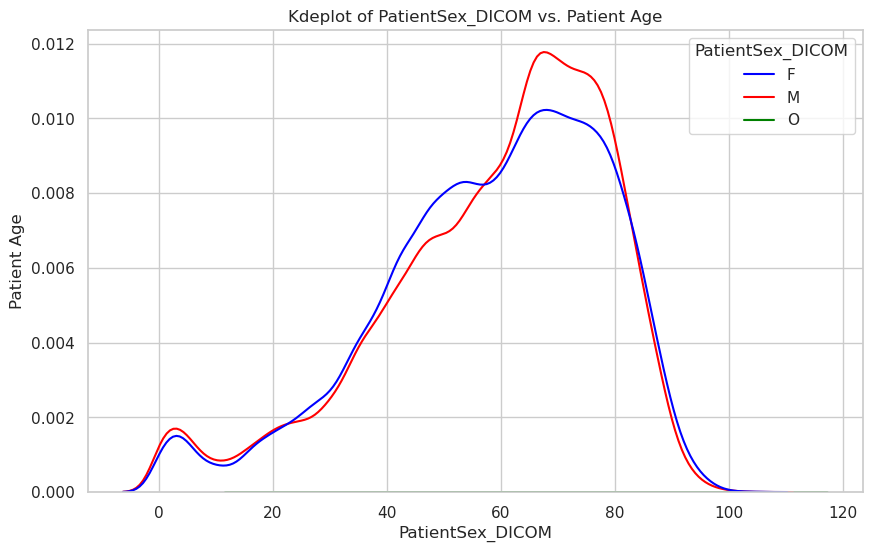

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="PatientAge", hue="PatientSex_DICOM", palette=["blue", "red", "green"])
plt.title("Kdeplot of PatientSex_DICOM vs. Patient Age")
plt.xlabel("PatientSex_DICOM")
plt.ylabel("Patient Age")
plt.show()

The category 'O' in the 'PatientSex_DICOM' column is quite limited, comprising only 18 samples. To enhance the data quality, I will proceed to remove these samples from the dataset.

In [10]:
print("Number of samples of category 'O' : ",  len(df[df.PatientSex_DICOM=='O']))

Number of samples of category 'O' :  18


In [11]:
df = df[df.PatientSex_DICOM!='O'].reset_index(drop=True)

### **Pediatric**
Interestingly, only 0.2% of patients are labeled as 'Pediatric,' indicating that they are children. However, upon examining the boxplot, it becomes evident that there are outliers present in both categories: 'PED' and 'NO PED.' To address this, I will rectify the situation by classifying patients with an age below 18 years as 'PED' (Pediatric) and those above 18 years as 'NO' (Non-Pediatric). This approach will help ensure that the pediatric classification accurately represents child patients while addressing the outliers observed in the dataset.

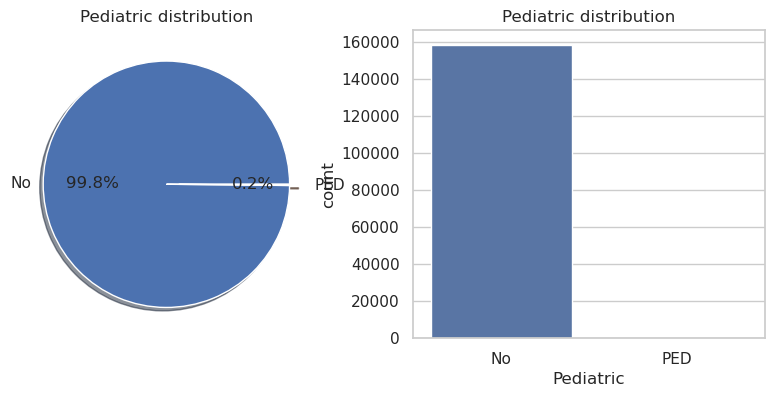

In [12]:
f,ax=plt.subplots(1,2,figsize=(10,4))
df['Pediatric'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Pediatric distribution')
ax[0].set_ylabel('')
sns.countplot(x=df['Pediatric'],ax=ax[1])
ax[1].set_title('Pediatric distribution')
plt.show()

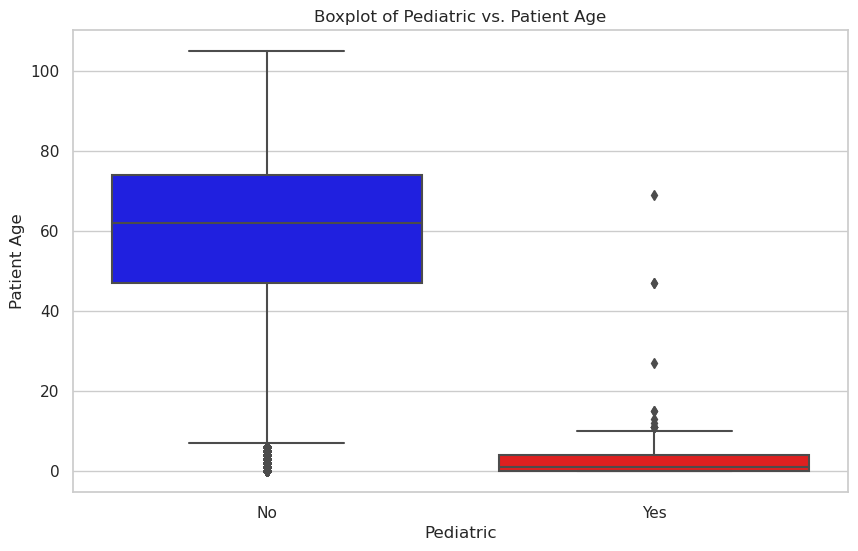

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Pediatric", y="PatientAge", palette=["blue", "red"])
plt.title("Boxplot of Pediatric vs. Patient Age")
plt.xlabel("Pediatric")
plt.ylabel("Patient Age")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

In [14]:
df["Pediatric"] = df.apply(lambda x : "PED" if x["PatientAge"]<18 else "NO", axis=1)

We check the new distribution of data labeled as "PED"

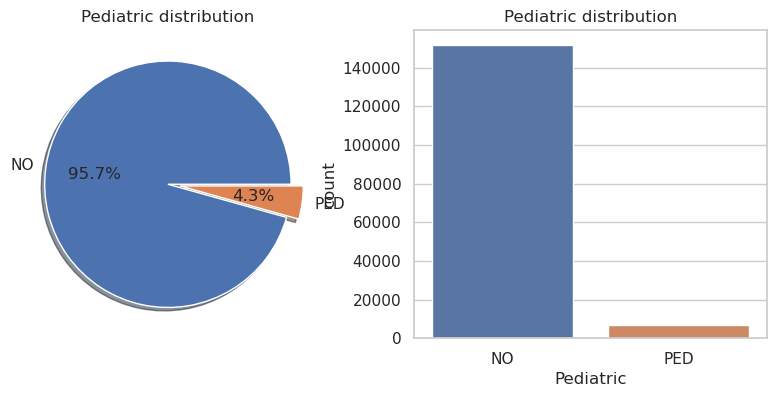

In [15]:
f,ax=plt.subplots(1,2,figsize=(10,4))
df['Pediatric'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Pediatric distribution')
ax[0].set_ylabel('')
sns.countplot(x=df['Pediatric'],ax=ax[1])
ax[1].set_title('Pediatric distribution')
plt.show()

### **ViewPosition_DICOM Feature**

* POSTEROANTERIOR (PA) : In this view, the X-ray beam travels from the back of the patient's body (posterior) to the front (anterior). 
* ANTEROPOSTERIOR (AP): In this view, the X-ray beam travels from the front of the patient's body (anterior) to the back (posterior).
* LATERAL (LL) : In this view, the X-ray beam passes through the patient's body from one side to the other, capturing structures from a lateral perspective.
* LLD : refers to the "Left Lateral" view.
* RL :  refers to the "Right Lateral" view.
* GENERICA : ?
* OBLICUA : ?

In [16]:
# Replace abbreviations in 'ViewPosition_DICOM' column with full names
df['ViewPosition_DICOM'].replace({'LL': 'LATERAL', 'LLD': 'LATERAL', 'RL': 'LATERAL', 'AP': 'ANTEROPOSTERIOR', 'PA': 'POSTEROANTERIOR'}, inplace=True)

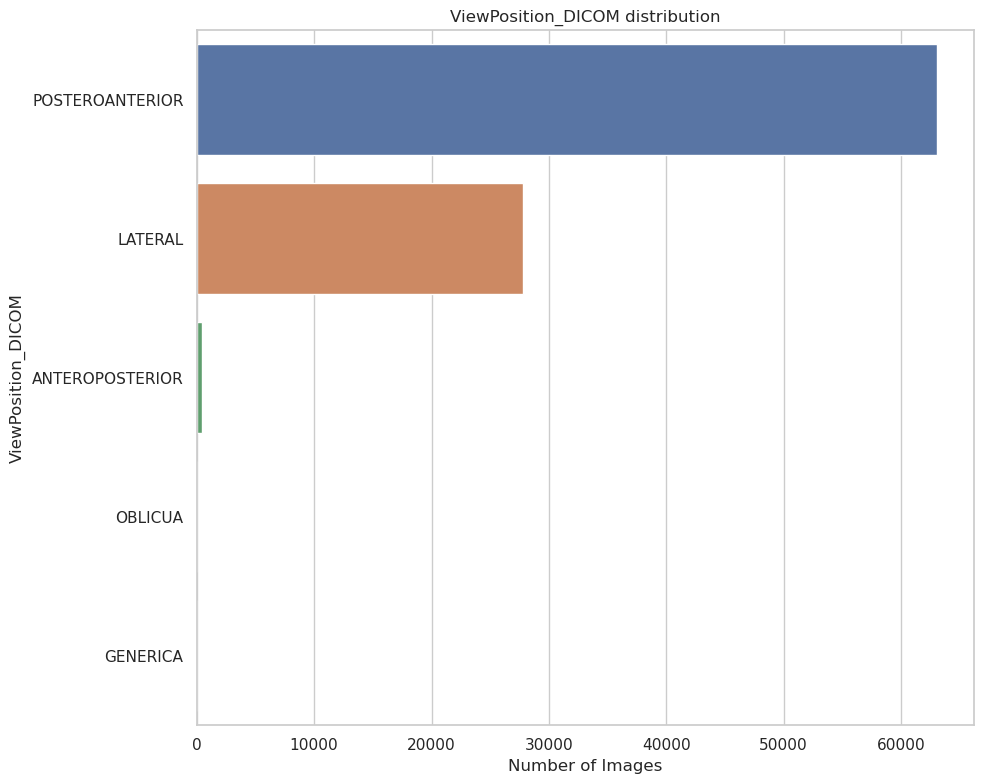

In [17]:
# Assuming top_labels_df contains your data
plt.figure(figsize=(10, 8))

# Limit the number of labels to show
N = 30  # Show the top N labels
top_labels = df['ViewPosition_DICOM'].value_counts().head(N).index
filtered_df = df[df['ViewPosition_DICOM'].isin(top_labels)]

sns.countplot(data=filtered_df, y='ViewPosition_DICOM', order=top_labels)  # Use y='Labels' for a horizontal plot
plt.title(f"ViewPosition_DICOM distribution")
plt.xlabel("Number of Images")
plt.ylabel("ViewPosition_DICOM")
plt.tight_layout()
plt.show()

In [18]:
# Keep only images with POSTEROANTERIOR or LATERAL view.
df = df[df.ViewPosition_DICOM.isin(['POSTEROANTERIOR', 'LATERAL'])].reset_index(drop=True)

Observation : Most X-ray images have a POSTEROANTERIOR or LATERAL view.

### **Projection Feature**
The following plot illustrates the percentage distribution of different 'Projection' techniques within each 'ViewPosition_DICOM' category. It demonstrates how the choice of projection techniques varies depending on whether the patient was positioned for a posterior-anterior ('PA') image or a lateral ('L') image. Notably, the lateral view positions consistently correspond to the 'lateral' projection technique. Additionally, almost all posterior-anterior view positions are associated with the 'PA' projection technique, while there is only one instance of the 'AP' ('Anteroposterior') projection technique.

<Figure size 1000x600 with 0 Axes>

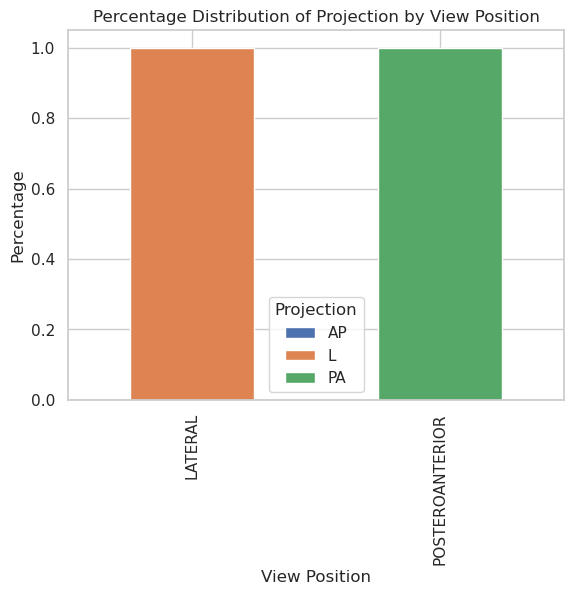

In [19]:
pivot_table = df.pivot_table(
    index="ViewPosition_DICOM", columns="Projection", aggfunc="size", fill_value=0
)
pivot_table = pivot_table.divide(pivot_table.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
pivot_table.plot(kind="bar", stacked=True)
plt.title("Percentage Distribution of Projection by View Position")
plt.xlabel("View Position")
plt.ylabel("Percentage")
plt.legend(title="Projection")
plt.xticks(rotation=90)
plt.show()

In [20]:
df = df[df['Projection'] != 'AP'].reset_index(drop=True)
df.drop(columns=['Projection'], axis=1, inplace=True)

### **Image Directory**
check images numbers in each directory (Original Padchest data)

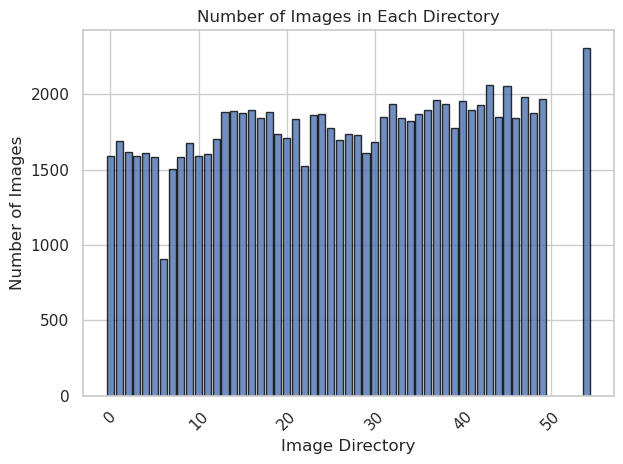

In [21]:
# Group the DataFrame by 'ImageDir' and count occurrences
grouped = df['ImageDir'].value_counts().sort_index()

# Create a bar plot
plt.bar(grouped.index, grouped.values, alpha=0.8, edgecolor='black')

plt.xlabel('Image Directory')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### **Labels Feature**
"normal", "COPD signs", "cardiomegal", "unchanged", "pleural effusion", "aerotic elongation", "pneumonia" and "scoliosis" are the most frequent labels in our dataset.

In [22]:
# Define a function to convert the string to a list only for non-NaN values
def convert_to_list(label_str):
    if pd.notna(label_str):
        try:
            return ast.literal_eval(label_str)
        except (ValueError, SyntaxError):
            pass
    return label_str

# Apply the conversion function to the 'Labels' column
df['Labels'] = df['Labels'].apply(convert_to_list)
df['Localizations'] = df['Localizations'].apply(convert_to_list)
df['LabelsLocalizationsBySentence'] = df['LabelsLocalizationsBySentence'].apply(convert_to_list)

# Explode the 'Labels' column to create individual rows for each label
exploded_df = df.explode(['Labels'], ignore_index=True)
exploded_df['Labels'] = exploded_df['Labels'].str.strip()

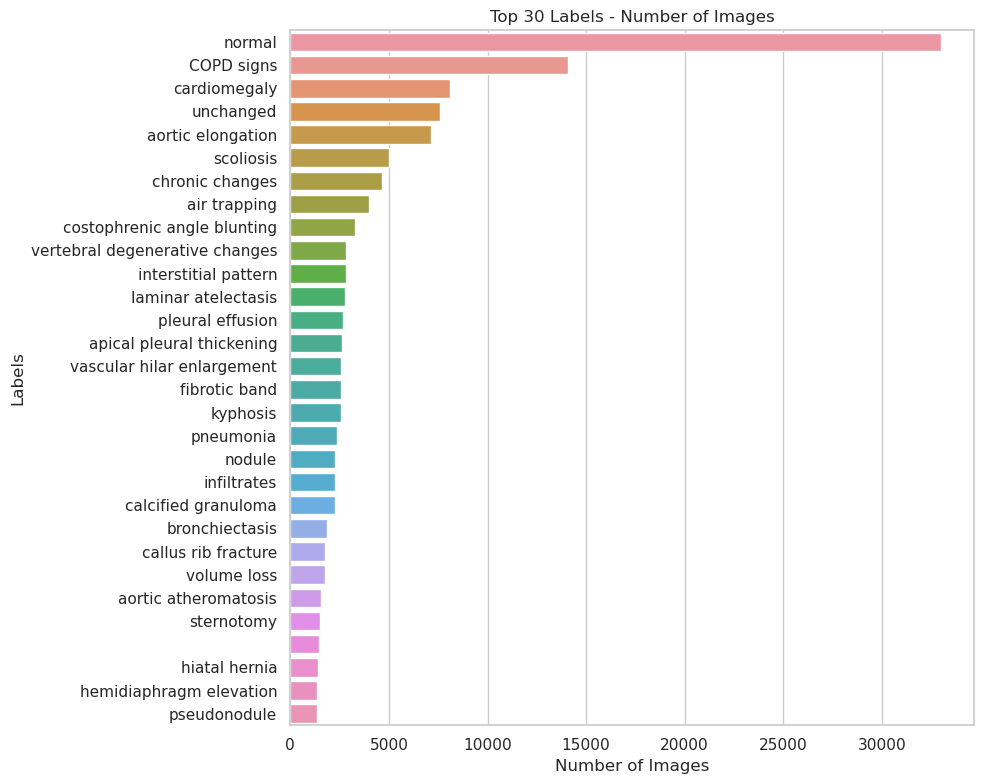

In [23]:
# Assuming top_labels_df contains your data
plt.figure(figsize=(10, 8))

# Limit the number of labels to show
N = 30  # Show the top N labels
top_labels = exploded_df['Labels'].value_counts().head(N).index
filtered_df = exploded_df[exploded_df['Labels'].isin(top_labels)]

sns.countplot(data=filtered_df, y='Labels', order=top_labels)  # Use y='Labels' for a horizontal plot
plt.title(f"Top {N} Labels - Number of Images")
plt.xlabel("Number of Images")
plt.ylabel("Labels")
plt.tight_layout()
plt.show()

#### **MethodLabel Feature**
After performing data cleaning, the dataset consists of 76.8% of reports that were automatically labeled using the RNN_model, and 23.2% of reports that were labeled manually by physicians.

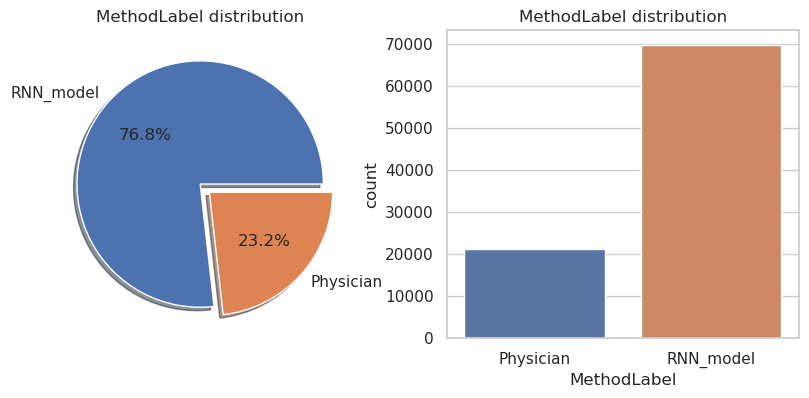

In [24]:
f,ax=plt.subplots(1,2,figsize=(10,4))
df['MethodLabel'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('MethodLabel distribution')
ax[0].set_ylabel('')
sns.countplot(x=df['MethodLabel'],ax=ax[1])
ax[1].set_title('MethodLabel distribution')
plt.show()

### **Dataset construction : (labels : pneumonia, normal)**

In [25]:
new_data_pneumonia_normal = exploded_df[(exploded_df.Labels=='normal') | (exploded_df.Labels=='pneumonia')].reset_index(drop=True)
new_data_pneumonia_normal.head()

,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge
0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient .,Physician,normal,[],"[[normal], [normal]]",84.0
1,238285621348398466668514178112618553012_a7k6dv...,0,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion .,Physician,normal,[],"[[normal], [normal]]",30.0
2,152191969602076825998375638267191596461_ck9qkz...,0,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific .,Physician,normal,[],[[normal]],57.0
3,84289138814897824414670894017743137660_xjsw7k.png,0,20140414,84289138814897824414670894017743137660,132905598244344199302356904572008903408,1997.0,F,POSTEROANTERIOR,4674875,PED,normal .,Physician,normal,[],"[[normal], [normal]]",17.0
4,243837679625088918208093479515843617254_zotvy7...,0,20160210,243837679625088918208093479515843617254,122113458248232192114674752959967366181,1976.0,F,LATERAL,5084816,NO,. . . . siluet cardiomediastin dentr normal ....,Physician,normal,"[loc cardiac, loc costophrenic angle]","[[normal], [normal], [normal, loc cardiac], [n...",40.0


To create a smaller subset of the data, we can choose to include only the entries that were labeled by physicians.

In [26]:
# To minimize The data size I choose to select only images labeled by Pysician
new_data_pneumonia_normal = new_data_pneumonia_normal[new_data_pneumonia_normal.MethodLabel=='Physician'].reset_index(drop=True)
new_data_pneumonia_normal.drop(columns=['ImageDir', 'StudyID', 'PatientID', 'ReportID'], inplace=True)

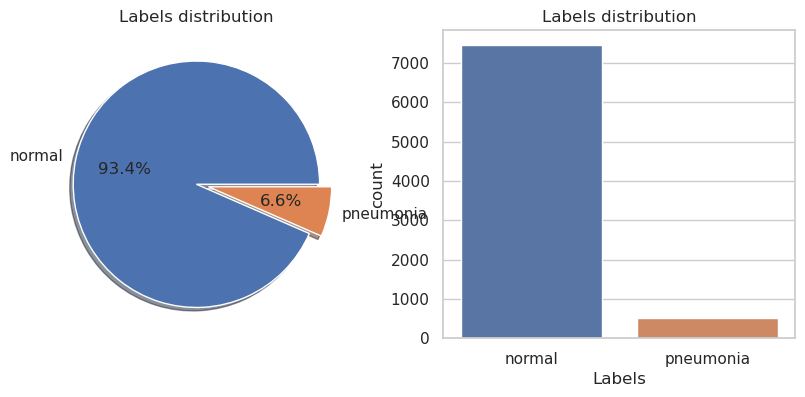

In [27]:
f,ax=plt.subplots(1,2,figsize=(10,4))
new_data_pneumonia_normal['Labels'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Labels distribution')
ax[0].set_ylabel('')
sns.countplot(x=new_data_pneumonia_normal['Labels'],ax=ax[1])
ax[1].set_title('Labels distribution')
plt.show()

Reports are written in Spanish language. We use Google Translator to translate them into English.

In [28]:
# Use of GoogleTranslator to translate from espagnol to english
new_data_pneumonia_normal.dropna(subset=['Report'], axis=0, inplace=True)
new_data_pneumonia_normal= new_data_pneumonia_normal.reset_index(drop=True)
# Remove punctuation from the 'Report' column
new_data_pneumonia_normal['Report'] = new_data_pneumonia_normal['Report'].apply(lambda x: re.sub(r'[^\w\s]', '', x)).str.strip()

In [29]:
translator = GoogleTranslator(source='es', target='en')  
new_data_pneumonia_normal['Report'] = new_data_pneumonia_normal['Report'].apply(lambda x : translator.translate(x) if pd.notna(x) else x)
new_data_pneumonia_normal.to_csv("padchest_normal_pneumonia.csv",index=False)

### **Dataset construction : (labels : cardiomegaly, normal)**

In [30]:
new_data_cardiomegaly_normal = exploded_df[(exploded_df.Labels=='normal') | (exploded_df.Labels=='cardiomegaly')].reset_index(drop=True)
new_data_cardiomegaly_normal.head()

,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge
0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient .,Physician,normal,[],"[[normal], [normal]]",84.0
1,238285621348398466668514178112618553012_a7k6dv...,0,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion .,Physician,normal,[],"[[normal], [normal]]",30.0
2,152191969602076825998375638267191596461_ck9qkz...,0,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific .,Physician,normal,[],[[normal]],57.0
3,84289138814897824414670894017743137660_xjsw7k.png,0,20140414,84289138814897824414670894017743137660,132905598244344199302356904572008903408,1997.0,F,POSTEROANTERIOR,4674875,PED,normal .,Physician,normal,[],"[[normal], [normal]]",17.0
4,243837679625088918208093479515843617254_zotvy7...,0,20160210,243837679625088918208093479515843617254,122113458248232192114674752959967366181,1976.0,F,LATERAL,5084816,NO,. . . . siluet cardiomediastin dentr normal ....,Physician,normal,"[loc cardiac, loc costophrenic angle]","[[normal], [normal], [normal, loc cardiac], [n...",40.0


In [31]:
# To minimize The data size I choose to select only images labeled by Pysician
new_data_cardiomegaly_normal = new_data_cardiomegaly_normal[new_data_cardiomegaly_normal.MethodLabel=='Physician'].reset_index(drop=True)
new_data_cardiomegaly_normal.drop(columns=['ImageDir', 'StudyID', 'PatientID', 'ReportID'], inplace=True)

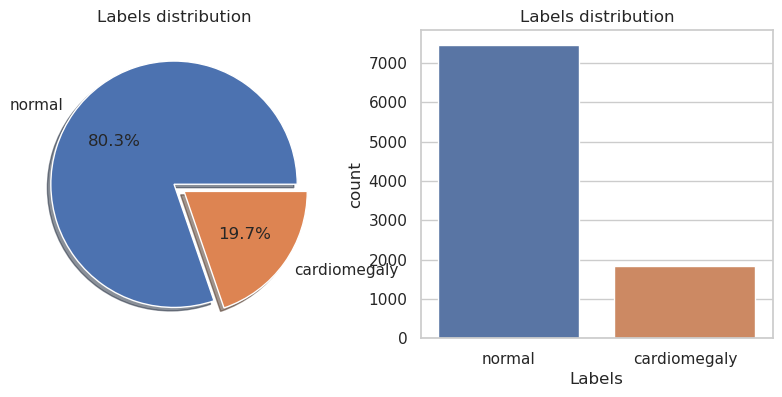

In [32]:
f,ax=plt.subplots(1,2,figsize=(10,4))
new_data_cardiomegaly_normal['Labels'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Labels distribution')
ax[0].set_ylabel('')
sns.countplot(x=new_data_cardiomegaly_normal['Labels'],ax=ax[1])
ax[1].set_title('Labels distribution')
plt.show()

In [33]:
# Use of GoogleTranslator to translate from espagnol to english
new_data_cardiomegaly_normal.dropna(subset=['Report'], axis=0, inplace=True)
new_data_cardiomegaly_normal= new_data_cardiomegaly_normal.reset_index(drop=True)
# Remove punctuation from the 'Report' column
new_data_cardiomegaly_normal['Report'] = new_data_cardiomegaly_normal['Report'].apply(lambda x: re.sub(r'[^\w\s]', '', x)).str.strip()

In [34]:
translator = GoogleTranslator(source='es', target='en')  
new_data_cardiomegaly_normal['Report'] = new_data_cardiomegaly_normal['Report'].apply(lambda x : translator.translate(x) if pd.notna(x) else x)
new_data_cardiomegaly_normal.to_csv("padchest_normal_cardiomegaly.csv",index=False)